# BTC or Stock Prediction
This time you’ll build a basic Deep Neural Network model to predict Bitcoin price based on historical data

- Cryptocurrency data overview
- Time Series
- Data preprocessing
- Build and train LSTM model in TensorFlow 2
- Use the model to predict future Bitcoin price


## BTC Price Data Crawler

In [14]:
from cryptocmd import CmcScraper

# initialise scraper with time interval
scraper = CmcScraper("BTC", "01-01-2018", "15-04-2023")

# get raw data as list of list
headers, data = scraper.get_data()

# get data in a json format
json_data = scraper.get_data("json")

# export the data to csv
scraper.export("csv")

# get dataframe for the data
maindf = scraper.get_dataframe()

## Show figure of Data

- Select the required data columns
- Set corresponding keys for the needed columns
- Configure x-axis and y-axis.

In [15]:
from itertools import cycle
import plotly.express as px

In [16]:
name = cycle(['stock close Price', 'stock open Price', 'stock High Price', 'stock low Price'])
fig = px.line(maindf, 
              x = maindf.Date, 
              y = [maindf['Close'], maindf['Open'], maindf['High'], maindf['Low']], 
              labels={'Date': 'Date', 'Value': 'Stock value'})
fig.update_layout(title_text = 'BitCoin Analysis Chart', 
                  font_size=15, 
                  font_color='black', 
                  legend_title = "bit coin market params")
fig.for_each_trace(lambda t: t.update(name = next(name)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [17]:
# Start build

data = maindf[['Date', 'Low', 'High', 'Close']]
data.shape[0]
_filter_data = data[data['Date'] > '01-01-2021']
_filter_stock = _filter_data.copy()

In [18]:
del _filter_data['Date']

# Data Preprocessing

Data preprocessing is a crucial step in the data analysis process. It transforms raw data into a format that can be easily and effectively analyzed to provide meaningful insights. Below are some common data preprocessing techniques:

## 1. **Normalization**
Normalization aims to scale the features to a similar range. One of the most common methods is [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), which scales the data between a specified range, usually (0,1). 

For example, in the context of Bitcoin prices, using `MinMaxScaler(feature_range=(0,1))` is beneficial because:
- It ensures that the price, which can vary significantly, doesn't disproportionately influence the model due to its magnitude.
- Neural networks often converge faster with values between 0 and 1.

## 2. **Standardization**
[Standardization](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) transforms the data to have a mean of zero and a standard deviation of one. It's useful when the features have different units.

## 3. **Data Cleaning**
This involves identifying and correcting (or removing) errors and inconsistencies in data to improve its quality. It involves handling missing data, smoothing noisy data, detecting and removing outliers, and resolving inconsistencies.

## 4. **One-Hot Encoding**
[One-Hot Encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) is used to convert categorical data into a format that can be provided to machine learning algorithms to improve predictions.

## 5. **Binning**
Binning is a data pre-processing technique used to reduce the effects of minor observation errors. The original data values which fall into a given small interval, a bin, are replaced by a value representative of that interval.

---

In conclusion, the choice of preprocessing technique largely depends on the nature of the data and the use case. For Bitcoin prices, given their volatility and magnitude, normalization using MinMaxScaler is often the most appropriate choice.


In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
# Data Preprocessing
# This step is to mitigate the impact of excessive data fluctuations on the model.

scaler = MinMaxScaler(feature_range=(0,1))
_filter_data = scaler.fit_transform(_filter_data) 


<hr/>

# Algorithm Article

 The reason I choose LSTM over RNN is that [LSTM](https://intellipaat.com/blog/what-is-lstm/#:~:text=LSTM%20Explained,-Now%2C%20let's%20understand&text='%20LSTM%20stands%20for%20long%20short,especially%20in%20sequence%20prediction%20problems.) (Long Short-Term Memory) networks are a type of (recurrent neural network [RNN](https://www.ibm.com/topics/recurrent-neural-networks#:~:text=the%20next%20step-,What%20are%20recurrent%20neural%20networks%3F,data%20or%20time%20series%20data.) specifically designed to avoid the long-term dependency problem. Traditional RNNs can struggle to learn and remember over long sequences and are particularly vulnerable to the [vanishing]((https://en.wikipedia.org/wiki/Vanishing_gradient_problem)) and [exploding](https://neptune.ai/blog/vanishing-and-exploding-gradients-debugging-monitoring-fixing) gradient problems. LSTM's unique design, with its gating mechanisms, allows it to remember and retain long-term dependencies, making it particularly suitable for time series forecasting tasks like predicting Bitcoin prices.


# LSTM (Long Short-Term Memory)

LSTM is a special kind of RNN, designed to avoid the long-term dependency problem. Its core idea revolves around the cell state, and it has three gates associated with it: the input gate, the forget gate, and the output gate.

## LSTM Equations

1. **Forget Gate**:
$$ f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) $$
This decides how much information we're going to throw away from the cell state.

2. **Input Gate**:
$$ i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) $$
$$ \tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C) $$
This decides what new information we're going to store in the cell state.

3. **Update Cell State**:
$$ C_t = f_t \times C_{t-1} + i_t \times \tilde{C}_t $$

4. **Output Gate**:
$$ o_t = \sigma(W_o [h_{t-1}, x_t] + b_o) $$
$$ h_t = o_t \times \tanh(C_t) $$
This decides what we're going to output based on the cell state, but filtered through a tanh function.

Where, 
$$ \sigma $$ is the sigmoid function, 
$$ W $$ and $$ b $$ are weights and biases, respectively, and these are parameters learned during training.


In [21]:
# Sets the length of the input sequences.
time_steps = 30

In [22]:
X, y = [], []
for i in range(len(_filter_data) - time_steps):
    X.append(_filter_data[i: i + time_steps])
    y.append(_filter_data[i + time_steps])

In [24]:
import numpy as np

In [25]:
X, y = np.array(X), np.array(y)

In [26]:
# Split data to Training set and Test set
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


### **1. Bidirectional**:
- In neural networks, especially recurrent neural networks (RNNs), a Bidirectional layer runs two RNNs simultaneously: one on the input sequence and another on its reversed version. This provides context from both past and future states, useful for sequences where both directions offer important context. [Read more](https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks)

### **2. Dropout**:
- Dropout is a regularization method in neural networks to prevent overfitting. During training, a fraction of neurons are randomly "turned off" at each iteration, ensuring the model doesn't rely too heavily on any specific neuron and promotes generalization. [Read more](https://jmlr.org/papers/v15/srivastava14a.html)

### **3. EarlyStopping**:
- Early stopping is a regularization technique to avoid overfitting in iterative training methods like gradient descent. It monitors the model's performance on a validation dataset and stops training once performance starts degrading. [Read more](https://en.wikipedia.org/wiki/Early_stopping)

### **4. Adam**:
- Adam (Adaptive Moment Estimation) is an optimization algorithm used to minimize the loss function in training machine learning models. An extension of stochastic gradient descent, it maintains a moving average of past gradients and adaptively adjusts learning rates for each parameter. [Read more](https://arxiv.org/abs/1412.6980)

### **5. Dense Layer (Fully Connected Layer)**:
- A Dense layer, also known as a fully connected layer, is a type of neural network layer where each input node is connected to each output node. It's commonly used in feedforward neural networks and is typically placed at the end of the network, after feature extraction and transformation layers, to produce final predictions. The Dense layer performs a linear operation on the layer's input, which can then be passed through a non-linear activation function. [Read more](https://en.wikipedia.org/wiki/Feedforward_neural_network)


In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
# 编译和训练模型
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

### Deep Learning Concepts Explained

**Layers**:
- In neural networks, layers are collections of nodes or neurons that process parts of the input data. The architecture you provided has multiple types of layers, including Bidirectional LSTM layers, Dropout layers, and Dense layers.

**Units**:
- Units refer to the number of neurons or nodes in a layer. For instance, in your LSTM layer, `best_n_units = 150` means there are 150 LSTM cells. [Source](https://en.wikipedia.org/wiki/Artificial_neural_network)

**Epoch**:
- An epoch refers to one complete forward and backward pass of all the training examples. The number of epochs is the number of times the learning algorithm will work through the entire training dataset. [Source](https://deepai.org/machine-learning-glossary-and-terms/epoch)

**Batch Size**:
- Batch size refers to the number of training examples utilized in one iteration. [Source](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/)

**lr (Learning Rate)**:
- The learning rate (`lr`) is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. [Source](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/)

**Patience (in Early Stopping)**:
- Patience is the number of epochs to wait before stopping the training process if no improvement in model performance is observed. [Source](https://keras.io/api/callbacks/early_stopping/)

**Loss Function**:
- The loss function (or objective function) measures the difference between the predicted values and the actual values. The goal during training is to minimize this difference. [Source](https://en.wikipedia.org/wiki/Loss_function)
    - **Mean Squared Error (MSE)**: Used for regression problems. It's the average of the squared differences between predicted and actual values.
    - **Cross-Entropy Loss**: Commonly used for classification problems.
    - **Mean Absolute Error (MAE)**: It's the average of the absolute differences between predictions and actual values.
    - **Huber Loss**: A combination of MSE and MAE, less sensitive to outliers than MSE.

In the provided architecture, the Mean Squared Error (MSE) loss function is used because it's commonly used for regression problems, ensuring that the model's predictions are close to the actual values. [Source](https://en.wikipedia.org/wiki/Mean_squared_error)


In [32]:
best_n_layers = 2
best_n_units = 150

best_model = Sequential()
best_model.add(Bidirectional(LSTM(units=best_n_units, return_sequences=True), input_shape=(time_steps, 3)))
best_model.add(Dropout(0.2))
best_model.add(Bidirectional(LSTM(units=best_n_units, return_sequences=False)))
best_model.add(Dropout(0.2))
best_model.add(Dense(units=50))
best_model.add(Dense(units=3))
optimizer = Adam(lr=0.0005)

best_model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = best_model.fit(X_train, y_train, validation_data=[X_test, y_test], epochs=400, batch_size=64, callbacks=[early_stopping])

Epoch 1/400
11/11 [==============================] - 3s 119ms/step - loss: 0.0465 - val_loss: 0.0230
Epoch 2/400
11/11 [==============================] - 1s 83ms/step - loss: 0.0091 - val_loss: 0.0185
Epoch 3/400
11/11 [==============================] - 1s 90ms/step - loss: 0.0071 - val_loss: 0.0123
Epoch 4/400
11/11 [==============================] - 1s 97ms/step - loss: 0.0047 - val_loss: 0.0079
Epoch 5/400
11/11 [==============================] - 1s 110ms/step - loss: 0.0040 - val_loss: 0.0077
Epoch 6/400
11/11 [==============================] - 1s 119ms/step - loss: 0.0033 - val_loss: 0.0067
Epoch 7/400
11/11 [==============================] - 1s 127ms/step - loss: 0.0031 - val_loss: 0.0068
Epoch 8/400
11/11 [==============================] - 1s 125ms/step - loss: 0.0033 - val_loss: 0.0063
Epoch 9/400
11/11 [==============================] - 2s 139ms/step - loss: 0.0033 - val_loss: 0.0126
Epoch 10/400
11/11 [==============================] - 1s 133ms/step - loss: 0.0061 - val_loss:

11/11 [==============================] - 2s 175ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 82/400
11/11 [==============================] - 2s 173ms/step - loss: 0.0010 - val_loss: 0.0028
Epoch 83/400
11/11 [==============================] - 2s 169ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 84/400
11/11 [==============================] - 2s 194ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 85/400
11/11 [==============================] - 2s 185ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 86/400
11/11 [==============================] - 2s 191ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 87/400
11/11 [==============================] - 2s 167ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 88/400
11/11 [==============================] - 2s 170ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 89/400
11/11 [==============================] - 2s 169ms/step - loss: 9.3090e-04 - val_loss: 0.0018
Epoch 90/400
11/11 [==============================] - 2s 156ms/step - loss: 9.9024e-04 - va

11/11 [==============================] - 1s 130ms/step - loss: 7.2276e-04 - val_loss: 0.0018
Epoch 159/400
11/11 [==============================] - 2s 140ms/step - loss: 7.9727e-04 - val_loss: 0.0017
Epoch 160/400
11/11 [==============================] - 2s 154ms/step - loss: 7.2154e-04 - val_loss: 0.0018
Epoch 161/400
11/11 [==============================] - 2s 149ms/step - loss: 7.8309e-04 - val_loss: 0.0022
Epoch 162/400
11/11 [==============================] - 2s 148ms/step - loss: 7.0212e-04 - val_loss: 0.0015
Epoch 163/400
11/11 [==============================] - 2s 179ms/step - loss: 6.9017e-04 - val_loss: 0.0014
Epoch 164/400
11/11 [==============================] - 2s 156ms/step - loss: 6.6219e-04 - val_loss: 0.0014
Epoch 165/400
11/11 [==============================] - 2s 165ms/step - loss: 6.7114e-04 - val_loss: 0.0018
Epoch 166/400
11/11 [==============================] - 2s 185ms/step - loss: 6.5880e-04 - val_loss: 0.0014
Epoch 167/400
11/11 [==============================

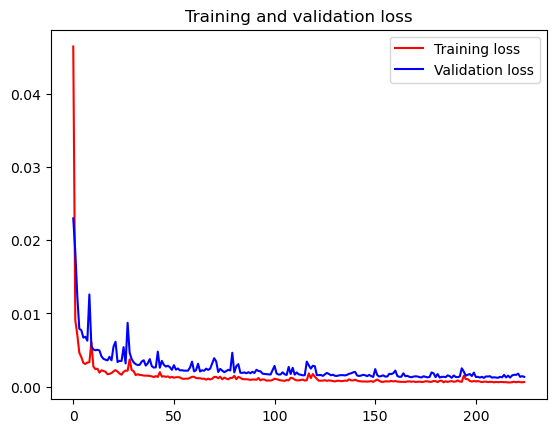

<Figure size 640x480 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()